# MgCoNiCuZnO Rocksalt VASP Example
*October 1, 2025*

This example goes over the special quasirandom structure (SQS) generation, VASP calculation setup, and analysis process using `pytheos` for a 128-atom supercell of the prototypical rocksalt high-entropy oxide $Mg_{1/5}Co_{1/5}Ni_{1/5}Cu_{1/5}Zn_{1/5}O$ (oftentimes this is referred to as "J14", which I do here in a few spots).

This example will make some comparisons for the calculations performed in our Acta Mat publication [(Link)](https://www.sciencedirect.com/science/article/abs/pii/S1359645424006396).

# Special Quasirandom Structure (SQS) Generation

In [ ]:
# First we will create a 4x4x4 SQS structure from the 2-atom primitive rocksalt unit cell that will total 128-atoms.

from ase.build import bulk
from pytheos.structure import generation, utils

# 2-atom rocksalt unit cell
prim_unitcell = bulk(name="MgO", crystalstructure="rocksalt", a = 4.20, cubic=False)

sqs_j14 = generation.make_sqs(
    structure=prim_unitcell,
    dimensions=(4, 4, 4),
    chemical_symbols=[["Mg", "Co", "Ni", "Cu", "Zn"], ["O"]],
    concentrations={"Mg": 13/64, "Co": 13/64, "Ni": 13/64, "Cu": 13/64, "Zn": 12/64}, # slightly non equimolar due to cell size constraints
    cutoffs=[5], # in angstroms
    num_mc_steps=1000000 # one million MC steps, could go higher if desired
    )

# it is always good practice to save your initial structure files to ensure that you are able to use them again
utils.write_structure(structure=sqs_j14, output_filename="MgCoNiCuZn_files/MgCoNiCuZnO_sqs_prim4x4x4.vasp")

icet.orbit_list: INFO  Done getting matrix_of_equivalent_positions.
icet.orbit_list: INFO  Done getting neighbor lists.
icet.orbit_list: INFO  Transformation of matrix of equivalent positions to lattice neighbor format completed.
icet.orbit_list: INFO  Finished construction of orbit list.
====================================== Cluster Space ======================================
 space group                            : Fm-3m (225)
 chemical species                       : ['Co', 'Cu', 'Mg', 'Ni', 'Zn'] (sublattice A)
 cutoffs                                : 5.0000
 total number of parameters             : 25
 number of parameters by order          : 0= 1  1= 4  2= 20
 fractional_position_tolerance          : 2e-06
 position_tolerance                     : 1e-05
 symprec                                : 1e-05
-------------------------------------------------------------------------------------------
index | order |  radius  | multiplicity | orbit_index | multicomponent_vector | sublat

The SQS generation output from above can be viewed [here](./MgCoNiCuZn_files/sqs_generation.out)

The SQS structure itself should look something like this:
<div>
<img src="./MgCoNiCuZnO_files/sqs_image.png" width="500"/>
</div>

# DFT Relaxation Setup

In [11]:
from pytheos.vasp import inputs
import os

In [ ]:
sqs = utils.read_structure(filename="MgCoNiCuZn_files/MgCoNiCuZnO_sqs_prim4x4x4.vasp")
print(sqs)
print(sqs.positions)

Atoms(symbols='Co13Cu13Mg13Ni13O64Zn12', pbc=True, cell=[[0.0, 8.4, 8.4], [8.4, 0.0, 8.4], [8.4, 8.4, 0.0]])
[[ 4.2  4.2  0. ]
 [ 6.3  6.3  0. ]
 [ 8.4  2.1  6.3]
 [ 0.   2.1  2.1]
 [ 6.3  6.3  4.2]
 [10.5  8.4  6.3]
 [ 4.2  8.4  4.2]
 [ 2.1  4.2  6.3]
 [ 4.2  6.3  6.3]
 [ 2.1  8.4  6.3]
 [ 2.1  6.3  8.4]
 [ 4.2  8.4  8.4]
 [ 6.3 10.5  8.4]
 [ 6.3  0.   6.3]
 [ 6.3  8.4  2.1]
 [ 4.2  4.2  4.2]
 [ 4.2  2.1  6.3]
 [ 6.3  4.2  6.3]
 [ 8.4  4.2  8.4]
 [ 6.3 10.5  4.2]
 [ 8.4 10.5  6.3]
 [ 4.2  4.2  8.4]
 [ 8.4 12.6  8.4]
 [10.5 12.6 10.5]
 [ 6.3  6.3 12.6]
 [ 0.   0.   0. ]
 [ 8.4  6.3  2.1]
 [ 4.2  0.   4.2]
 [ 6.3  2.1  4.2]
 [ 8.4  4.2  4.2]
 [10.5  4.2  6.3]
 [12.6  6.3  6.3]
 [ 4.2  6.3  2.1]
 [ 8.4  8.4  4.2]
 [10.5  6.3  8.4]
 [ 6.3  8.4  6.3]
 [ 8.4  8.4  8.4]
 [12.6 12.6 12.6]
 [ 2.1  2.1  0. ]
 [ 4.2  2.1  2.1]
 [ 6.3  4.2  2.1]
 [ 2.1  4.2  2.1]
 [ 8.4  6.3  6.3]
 [12.6  8.4  8.4]
 [ 6.3  6.3  8.4]
 [ 6.3  4.2 10.5]
 [12.6 10.5 10.5]
 [ 0.   6.3  6.3]
 [ 4.2  6.3 10.5]
 [ 6.3  8

In [ ]:
relaxation = inputs.CalcInputs(sqs)
relaxation.apply_mag_order(
    magmom_values={"Mg": 0.5, "Co": 5, "Ni": 5, "Cu": 3, "Zn": 0.5, "O": 0.5},
    mag_order_file="MgCoNiCuZn_files/magorder_MgO_AFMII.yaml",
    rattle_amount=0.5, # breaks initial magnetic symmetry for supplied magnetic ordering
)

# to observe how the initial MAGMOMs are rattled/distorted to break the initial magnetic symmetry
# NOTE that these follow the atom order within the SQS structure (POSCAR)
print(relaxation.poscar)
print(f"MAGMOM: {relaxation.incar["MAGMOM"]}")

Mg13 Zn12 Co13 Cu13 Ni13 O64
1.0
   0.0000000000000000    8.4000000000000004    8.4000000000000004
   8.4000000000000004    0.0000000000000000    8.4000000000000004
   8.4000000000000004    8.4000000000000004    0.0000000000000000
Mg Zn Co Cu Ni O
13 12 13 13 13 64
direct
   0.0000000000000000    0.0000000000000000    0.5000000000000000 Mg
   0.0000000000000000    0.0000000000000000    0.7500000000000000 Mg
   0.0000000000000000    0.7500000000000000    0.2500000000000000 Mg
   0.2500000000000000    0.0000000000000000    0.0000000000000000 Mg
   0.2499999999999999    0.2499999999999999    0.5000000000000001 Mg
   0.2500000000000002    0.5000000000000002    0.7499999999999998 Mg
   0.4999999999999999   -0.0000000000000001    0.5000000000000001 Mg
   0.5000000000000000    0.2500000000000000    0.0000000000000000 Mg
   0.5000000000000000    0.2500000000000002    0.2499999999999999 Mg
   0.7500000000000000    0.0000000000000001    0.2499999999999999 Mg
   0.7500000000000000    0.2500000000

/storage/work/jts6114/.conda/envs/pytheos/lib/python3.12/site-packages/pymatgen/io/vasp/sets.py:486: BadInputSetWarning: POTCAR data with symbol Mg_pv is not known by pymatgen to correspond with the selected user_potcar_functional='PBE_54'. This POTCAR is known to correspond with functionals ['PBE_64', 'PBE_52_W_HASH', 'PBE_54_W_HASH']. Please verify that you are using the right POTCARs!
  potcar="\n".join(self.potcar_symbols) if potcar_spec else self.potcar,
/storage/work/jts6114/.conda/envs/pytheos/lib/python3.12/site-packages/pymatgen/io/vasp/sets.py:486: BadInputSetWarning: POTCAR data with symbol Zn is not known by pymatgen to correspond with the selected user_potcar_functional='PBE_54'. This POTCAR is known to correspond with functionals ['PBE_64', 'PBE_52_W_HASH', 'PBE_54_W_HASH']. Please verify that you are using the right POTCARs!
  potcar="\n".join(self.potcar_symbols) if potcar_spec else self.potcar,
/storage/work/jts6114/.conda/envs/pytheos/lib/python3.12/site-packages/pyma

In [ ]:
relaxation.write_files(output_dir="MgCoNiCuZn_files/relaxation")

os.system("cp ../scripts/submitvasp MgCoNiCuZn_files/relaxation/submitvasp")
os.system("cp ../scripts/cstdn_vasp_doublerelax.py MgCoNiCuZn_files/relaxation/cstdn.py")

0

NOTE I am going to slightly change the `cstdn.py` file manually to expedite this calculation with the `vasp_gam` executable for Gamma-point only calculations

In [ ]:
# Now let's rattle the initial strcture of this structure so that we can break the initial structural symmetry as well (*very* good practice to do in HEO calculations especially, but can be important in many calculations)

from pytheos.structure import utils

os.system("cp MgCoNiCuZn_files/relaxation/POSCAR MgCoNiCuZn_files/relaxation/POSCAR_unrattled")
poscar = utils.read_structure(filename="MgCoNiCuZn_files/relaxation/POSCAR")
poscar_rattled = utils.rattle_atoms(structure=poscar)
utils.write_structure(structure=poscar_rattled, output_filename="MgCoNiCuZn_files/relaxation/POSCAR", overwrite=True)
print(poscar_rattled.positions)

[[ 4.19583242e+00  4.19943733e+00 -2.13619610e-02]
 [ 6.31640271e+00  6.28206564e+00 -8.41747366e-03]
 [ 8.40502881e+00  2.08754712e+00  6.28942048e+00]
 [-9.09007615e-03  2.10551454e+00  2.12292208e+00]
 [ 6.30041539e+00  6.28882075e+00  4.20539058e+00]
 [ 1.04940384e+01  8.39980870e+00  6.31175001e+00]
 [ 4.19252129e+00  8.40009025e+00  4.19121892e+00]
 [ 2.09843566e+00  4.20256570e+00  6.29011221e+00]
 [ 4.19661178e+00  6.29763816e+00  6.29362345e+00]
 [ 2.08812388e+00  8.38578783e+00  6.29846505e+00]
 [ 2.09730943e+00  6.32231367e+00  8.37565232e+00]
 [ 4.20112727e+00  8.40370445e+00  8.41359634e+00]
 [ 6.30501857e+00  1.04915579e+01  8.40000010e+00]
 [ 6.30542353e+00 -3.13508197e-03  6.30771012e+00]
 [ 6.28131909e+00  8.41731185e+00  2.11467678e+00]
 [ 4.19664323e+00  4.20611341e+00  4.20047971e+00]
 [ 4.19170865e+00  2.10087710e+00  6.31000366e+00]
 [ 6.29618907e+00  4.19624331e+00  6.29925529e+00]
 [ 8.40433496e+00  4.21278379e+00  8.39365321e+00]
 [ 6.30508396e+00  1.05021612e+

*Now you are ready to run your relaxation*

In [2]:
# once the relaxation has finished, we now can make the DOS calculation from which we will extract our predictions
from pytheos.vasp.modifiers import CalcModifier
import os

j14_calc_mod = CalcModifier(source_dir="MgCoNiCuZnO_files/relaxation")
j14_calc_mod.to_dos()

j14_calc_mod.write_files(output_dir="MgCoNiCuZnO_files/dos")
os.system("cp ../scripts/cstdn_vasp.py MgCoNiCuZnO_files/dos/cstdn.py")

0

Once the DOS calculation has finished, we can start to explore the resulting predictions for our J14 SQS using DFT...

# Local Atomic Structure

In [1]:
from pytheos.vasp import outputs
from pytheos.structure import analysis

j14_outputs = outputs.CalcOutputs(source_dir="MgCoNiCuZnO_files/dos")

In [2]:
extracted_bondlengths = analysis.extract_firstNN_bonds(struc=j14_outputs.structure, num_NNs=6)


atom #0 (Mg)
 radius = 3.0 Å
 bondlengths = [2.045 2.138 2.119 2.067 2.095 2.072] Å

atom #1 (Mg)
 radius = 3.0 Å
 bondlengths = [2.175 2.081 2.091 2.079 2.122 2.078] Å

atom #2 (Mg)
 radius = 3.0 Å
 bondlengths = [2.097 2.027 2.033 2.104 2.101 2.143] Å

atom #3 (Mg)
 radius = 3.0 Å
 bondlengths = [2.148 2.034 2.101 2.049 2.169 2.145] Å

atom #4 (Mg)
 radius = 3.0 Å
 bondlengths = [2.119 2.122 2.092 2.08  2.117 2.089] Å

atom #5 (Mg)
 radius = 3.0 Å
 bondlengths = [2.095 2.066 2.136 2.07  2.141 2.109] Å

atom #6 (Mg)
 radius = 3.0 Å
 bondlengths = [2.108 2.108 2.102 2.107 2.091 2.078] Å

atom #7 (Mg)
 radius = 3.0 Å
 bondlengths = [2.119 2.144 2.059 2.063 2.134 2.109] Å

atom #8 (Mg)
 radius = 3.0 Å
 bondlengths = [2.123 2.144 2.04  2.039 2.115 2.123] Å

atom #9 (Mg)
 radius = 3.0 Å
 bondlengths = [2.112 2.067 2.15  2.08  2.153 2.073] Å

atom #10 (Mg)
 radius = 3.0 Å
 bondlengths = [2.178 2.025 2.096 2.109 2.096 2.106] Å

atom #11 (Mg)
 radius = 3.0 Å
 bondlengths = [2.075 2.181 2.068

In [3]:
extracted_bondlengths

,species,distance,anion index
0,Mg,2.045065,94
1,Mg,2.137757,65
2,Mg,2.119291,66
3,Mg,2.066758,81
4,Mg,2.094841,78
...,...,...,...
379,Ni,2.133667,74
380,Ni,2.098417,77
381,Ni,2.125658,125
382,Ni,2.072907,122


(array([  8.,  17.,  70., 136.,  93.,  28.,  13.,   8.,   6.,   5.]),
 array([1.91577952, 1.96714076, 2.018502  , 2.06986323, 2.12122447,
        2.17258571, 2.22394695, 2.27530818, 2.32666942, 2.37803066,
        2.42939189]),
 <BarContainer object of 10 artists>)

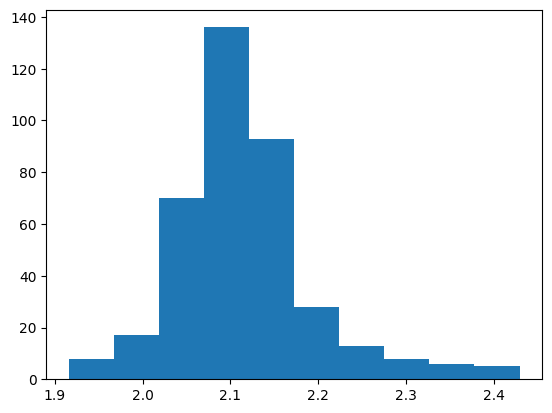

In [9]:
import matplotlib.pyplot as plt

plt.hist(extracted_bondlengths["distances"])